# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

import warnings

warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('azdias.csv', index_col=0)
customers = pd.read_csv('customers.csv', index_col=0)

### AZDIAS Dataset

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
azdias.shape

(891221, 366)

### CUSTOMERS Dataset

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 541.0+ MB


In [8]:
customers.shape

(191652, 369)

### Preprocess Data

I will only use variables available in the Excel file (DIAS Attributes - Values 2017.xlsx). The customers and azdias dataset each has 366 and 369 columns (including the identifier column) and we will drop columns that are not in the Excel file.

In [9]:
attributes = pd.read_csv('attributes metadata v2.csv')

In [10]:
attributes.head()

,Attributes,Variable Type,Missing Values
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"


In [11]:
attributes.shape

(334, 3)

In [12]:
features_in_att = attributes['Attributes'].tolist()
features_in_att

['AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 

In [13]:
len(features_in_att)

334

In [14]:
to_drop_nonexistent = list(set(azdias) - set(features_in_att))
to_drop_nonexistent_c = list(set(customers) - set(features_in_att))

In [15]:
azdias.drop(labels=to_drop_nonexistent, axis=1, inplace=True)
customers.drop(labels=to_drop_nonexistent_c, axis=1, inplace=True)

In [16]:
len(to_drop_nonexistent)

32

In [17]:
len(to_drop_nonexistent_c)

35

In [18]:
azdias.shape

(891221, 334)

In [19]:
customers.shape

(191652, 334)

### Convert to float for features that are marked as float in attributes metadata

In [22]:
#Convert to float - Azdias
for column in azdias.columns:
    if azdias[column].dtype == np.int64:
        azdias[column] = azdias[column].astype(np.float64)

In [23]:
#Convert to float - Customers
for column in customers.columns:
    if customers[column].dtype == np.int64:
        customers[column] = customers[column].astype(np.float64)

### Remove missing data

In [20]:
missing_value_series = pd.Series(attributes['Missing Values'].values, index=attributes['Attributes'])

In [21]:
missing_value_series 

Attributes
AGER_TYP                  [-1,0]
ALTERSKATEGORIE_FEIN    [-1,0.9]
ALTERSKATEGORIE_GROB    [-1,0,9]
ALTER_HH                     [0]
ANREDE_KZ                 [-1,0]
                          ...   
VERS_TYP                    [-1]
WOHNDAUER_2008            [-1,0]
WOHNLAGE                  [-1,0]
W_KEIT_KIND_HH            [-1,0]
ZABEOTYP                  [-1,9]
Length: 334, dtype: object

In [24]:
#Label missing value - Azdias
for column in azdias.columns:
    
    isin = ast.literal_eval(missing_value_series[column])
    
    azdias[column] = azdias[column].mask(azdias[column].isin(isin), other=np.nan)

In [25]:
#Label missing value - Customers
for column in customers.columns:
    
    isin = ast.literal_eval(missing_value_series[column])
    
    customers[column] = customers[column].mask(customers[column].isin(isin), other=np.nan)

In [26]:
missing_perct_column = azdias.isnull().mean(axis=0)
missing_perct_column

AGER_TYP                0.769554
ALTER_HH                0.348137
ALTERSKATEGORIE_FEIN    0.295041
ANZ_HAUSHALTE_AKTIV     0.104517
ANZ_HH_TITEL            0.108848
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.112316
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.003233
Length: 334, dtype: float64

Text(0.5, 1.0, 'Proportion of NaN Values in azdias Columns')

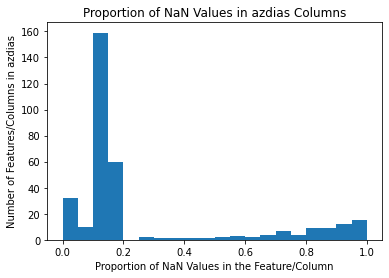

In [27]:
plt.hist(missing_perct_column, bins=20);

plt.xlabel('Proportion of NaN Values in the Feature/Column')
plt.ylabel('Number of Features/Columns in azdias')
plt.title('Proportion of NaN Values in azdias Columns')

In [28]:
to_drop_missing = missing_perct_column[missing_perct_column > 0.2].index
azdias.drop(labels=to_drop_missing, axis=1, inplace=True)
customers.drop(labels=to_drop_missing, axis=1, inplace=True)

In [29]:
azdias.shape

(891221, 261)

In [30]:
customers.shape

(191652, 261)

In [31]:
missing_perct_row = azdias.isnull().mean(axis=1)
missing_perct_row

0         0.862069
1         0.000000
2         0.000000
3         0.030651
4         0.000000
            ...   
891216    0.011494
891217    0.015326
891218    0.022989
891219    0.000000
891220    0.000000
Length: 891221, dtype: float64

In [32]:
azdias = azdias[missing_perct_row < 0.2]
customers = customers[missing_perct_row < 0.2]

In [33]:
azdias.shape

(737288, 261)

In [34]:
customers.shape

(159036, 261)

### Re-encoding of Features

In [37]:
#categorical features from list of attributes, not dataset
categorical_features_attributes = attributes['Attributes'].loc[attributes['Variable Type'] == 'categorical']

categorical_features_attributes

0              AGER_TYP
4             ANREDE_KZ
13      CAMEO_DEUG_2015
14       CAMEO_DEU_2015
16        CJT_GESAMTTYP
46        D19_KONSUMTYP
83             DSL_FLAG
86            FINANZTYP
93          GEBAEUDETYP
96      GFK_URLAUBERTYP
97     GREEN_AVANTGARDE
99        HH_DELTA_FLAG
284        KK_KUNDENTYP
286         KONSUMZELLE
287     LP_FAMILIE_FEIN
288     LP_FAMILIE_GROB
291      LP_STATUS_FEIN
292      LP_STATUS_GROB
296    NATIONALITAET_KZ
299         OST_WEST_KZ
325         SHOPPER_TYP
326             SOHO_KZ
327            TITEL_KZ
328    UNGLEICHENN_FLAG
329            VERS_TYP
333            ZABEOTYP
Name: Attributes, dtype: object

In [38]:
#categorical features from azdias dataset
categorical_features_azdias = []

for feature in categorical_features_attributes:
    
    if feature in azdias.columns:
        
        print(feature + ', feature from attributes, is also a feature/column of azdias.')
        
        categorical_features_azdias.append(feature)


print('There are ' + str(len(categorical_features_attributes)) + ' categorical features in attributes, and ' 
      + str(len(categorical_features_azdias)) + ' categorical features in azdias.')

ANREDE_KZ, feature from attributes, is also a feature/column of azdias.
CAMEO_DEUG_2015, feature from attributes, is also a feature/column of azdias.
CAMEO_DEU_2015, feature from attributes, is also a feature/column of azdias.
CJT_GESAMTTYP, feature from attributes, is also a feature/column of azdias.
DSL_FLAG, feature from attributes, is also a feature/column of azdias.
FINANZTYP, feature from attributes, is also a feature/column of azdias.
GEBAEUDETYP, feature from attributes, is also a feature/column of azdias.
GFK_URLAUBERTYP, feature from attributes, is also a feature/column of azdias.
GREEN_AVANTGARDE, feature from attributes, is also a feature/column of azdias.
HH_DELTA_FLAG, feature from attributes, is also a feature/column of azdias.
KONSUMZELLE, feature from attributes, is also a feature/column of azdias.
LP_FAMILIE_FEIN, feature from attributes, is also a feature/column of azdias.
LP_FAMILIE_GROB, feature from attributes, is also a feature/column of azdias.
LP_STATUS_FEIN, f

In [39]:
#categorical features from customers dataset
categorical_features_customers = []

for feature in categorical_features_attributes:
    
    if feature in customers.columns:
        
        print(feature + ', feature from attributes, is also a feature/column of customers.')
        
        categorical_features_customers.append(feature)


print('There are ' + str(len(categorical_features_attributes)) + ' categorical features in attributes, and ' 
      + str(len(categorical_features_customers)) + ' categorical features in customers.')

ANREDE_KZ, feature from attributes, is also a feature/column of customers.
CAMEO_DEUG_2015, feature from attributes, is also a feature/column of customers.
CAMEO_DEU_2015, feature from attributes, is also a feature/column of customers.
CJT_GESAMTTYP, feature from attributes, is also a feature/column of customers.
DSL_FLAG, feature from attributes, is also a feature/column of customers.
FINANZTYP, feature from attributes, is also a feature/column of customers.
GEBAEUDETYP, feature from attributes, is also a feature/column of customers.
GFK_URLAUBERTYP, feature from attributes, is also a feature/column of customers.
GREEN_AVANTGARDE, feature from attributes, is also a feature/column of customers.
HH_DELTA_FLAG, feature from attributes, is also a feature/column of customers.
KONSUMZELLE, feature from attributes, is also a feature/column of customers.
LP_FAMILIE_FEIN, feature from attributes, is also a feature/column of customers.
LP_FAMILIE_GROB, feature from attributes, is also a feature

In [40]:
mixed_features_attributes = attributes['Attributes'].loc[attributes['Variable Type'] == 'mixed']

mixed_features_attributes

15           CAMEO_INTL_2015
289      LP_LEBENSPHASE_FEIN
290      LP_LEBENSPHASE_GROB
307    PRAEGENDE_JUGENDJAHRE
Name: Attributes, dtype: object

In [41]:
mixed_features_azdias = [] # mixed features (in attributes) that are also in azdias

for feature in mixed_features_attributes:
    
    if feature in azdias.columns:
        
        print(feature + ', feature from attributes, is also a feature/column of azdias.')
        
        mixed_features_azdias.append(feature)


print('There are ' + str(len(mixed_features_attributes)) + ' mixed features in attributes, and ' 
      + str(len(mixed_features_azdias)) + ' mixed features in azdias.')

CAMEO_INTL_2015, feature from attributes, is also a feature/column of azdias.
LP_LEBENSPHASE_FEIN, feature from attributes, is also a feature/column of azdias.
LP_LEBENSPHASE_GROB, feature from attributes, is also a feature/column of azdias.
PRAEGENDE_JUGENDJAHRE, feature from attributes, is also a feature/column of azdias.
There are 4 mixed features in attributes, and 4 mixed features in azdias.


In [42]:
mixed_features_customers = [] 

for feature in mixed_features_attributes:
    
    if feature in customers.columns:
        
        print(feature + ', feature from attributes, is also a feature/column of customers.')
        
        mixed_features_customers.append(feature)


print('There are ' + str(len(mixed_features_attributes)) + ' mixed features in attributes, and ' 
      + str(len(mixed_features_customers)) + ' mixed features in customers.')

CAMEO_INTL_2015, feature from attributes, is also a feature/column of customers.
LP_LEBENSPHASE_FEIN, feature from attributes, is also a feature/column of customers.
LP_LEBENSPHASE_GROB, feature from attributes, is also a feature/column of customers.
PRAEGENDE_JUGENDJAHRE, feature from attributes, is also a feature/column of customers.
There are 4 mixed features in attributes, and 4 mixed features in customers.


#### 1. Categorical to Numerical

In [43]:
cat_binary_numerical = []
cat_binary_nonnumerical = []
cat_multilevel = []

for attribute in categorical_features_azdias:
    dtype = azdias[attribute].dtype
    count = len(azdias[attribute].value_counts())

    # if multi-level categorical feature
    if count > 2:
        cat_multilevel.append(attribute)
    else:
        if dtype == 'object':
            cat_binary_nonnumerical.append(attribute)
        else:
            cat_binary_numerical.append(attribute)

In [44]:
cat_binary_numerical

['ANREDE_KZ',
 'DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP']

In [45]:
cat_binary_nonnumerical

['OST_WEST_KZ']

In [46]:
cat_multilevel

['CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP']

In [47]:
cat_binary_numerical_c = []
cat_binary_nonnumerical_c = []
cat_multilevel_c = []

for attribute in categorical_features_customers:
    dtype = customers[attribute].dtype
    count = len(customers[attribute].value_counts())

    # if multi-level categorical feature
    if count > 2:
        cat_multilevel_c.append(attribute)
    else:
        if dtype == 'object':
            cat_binary_nonnumerical_c.append(attribute)
        else:
            cat_binary_numerical_c.append(attribute)

In [48]:
cat_binary_numerical_c

['ANREDE_KZ',
 'DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP']

In [49]:
cat_binary_nonnumerical_c

['OST_WEST_KZ']

In [50]:
cat_multilevel_c

['CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP']

In [51]:
#Re-encoding Binary Non-Numerical

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].map({'W': 1, 'O': 2})

#Re-encoding MultiLevel

list_columns_to_add = []
list_columns_to_add_c = []

#AZDIAS
for column in cat_multilevel:
    
    # delete features with 10 or more levels - only select those with less than 10
    if len(azdias[column].value_counts()) < 10:
        list_columns_to_add.append(pd.get_dummies(azdias[column], prefix=column))
        
    
# drop the original
azdias.drop(cat_multilevel, axis=1, inplace=True)

list_columns_to_add.append(azdias) 

# add the re-encoded
azdias = pd.concat(list_columns_to_add, axis=1)

In [52]:
#CUSTOMERS
for column in cat_multilevel_c:
    
    # delete features with 10 or more levels - only select those with less than 10
    if len(customers[column].value_counts()) < 10:
        list_columns_to_add_c.append(pd.get_dummies(customers[column], prefix=column))
        
    
# drop the original
customers.drop(cat_multilevel_c, axis=1, inplace=True)

list_columns_to_add_c.append(customers) 

# add the re-encoded
customers = pd.concat(list_columns_to_add_c, axis=1)

In [53]:
# Check
azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,0,0,0,0,1,0,1,0,0,0,...,6.0,1.0,1.0,1.0,2.0,3.0,9.0,4.0,2.0,1.0
2,0,0,1,0,0,0,1,0,0,0,...,3.0,4.0,0.0,0.0,1.0,3.0,9.0,2.0,2.0,3.0
3,0,1,0,0,0,0,0,0,0,0,...,4.0,4.0,0.0,0.0,1.0,NaN,9.0,7.0,2.0,4.0
4,0,0,0,0,1,0,0,0,0,0,...,2.0,7.0,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0
5,0,1,0,0,0,0,0,1,0,0,...,6.0,2.0,0.0,0.0,2.0,6.0,9.0,7.0,2.0,1.0


In [54]:
azdias.shape

(737288, 290)

In [55]:
customers.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,0,0,0,0,0,0,0,1,0,0,...,1.0,7.0,0.0,0.0,1.0,NaN,9.0,NaN,1.0,4.0
2,0,1,0,0,0,0,0,1,0,0,...,1.0,3.0,0.0,0.0,2.0,6.0,9.0,2.0,2.0,4.0
3,0,1,0,0,0,0,0,0,0,0,...,4.0,7.0,0.0,0.0,1.0,NaN,9.0,7.0,1.0,4.0
4,0,0,0,0,0,1,0,1,0,0,...,4.0,5.0,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0
5,0,0,0,1,0,0,0,0,0,0,...,4.0,7.0,0.0,0.0,2.0,6.0,9.0,1.0,1.0,3.0


In [56]:
customers.shape

(159036, 289)

We note that the customers dataset has one column short (`GEBAEUDETYP_5.0`) due to the value `GEBAEUDETYP`=5 not being present in the customer dataset.

#### 2. Mixed to Numerical

In [57]:
mixed_features_azdias

['CAMEO_INTL_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE']

The DIAS Attributes - Values 2017 file shows us that columns `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` can take on numerous values and thus making them quite complex compared to the other features thus these columns are dropped.

On the other hand, the `PRAEGENDE_JUGENDJAHRE` column can be re-encoded into a new column which will take on either 0 or 1 as a value for each row of the dataset, with 0 refering to 'Mainstream' and 1 to ' Avantgarde' according to the original values from -1 to 15.

We will also need to re-encode the `CAMEO_INTL_2015` since it actually contains 2 variables, one being the level of wealth and the other being status.

In [58]:
# Function to reencode 'PRAEGENDE_JUGENDJAHRE'
def encode_pj(value): 
    newvalue = 0
    if value in [2, 4, 6, 7, 9, 11, 13, 15]:
        newvalue = 1
    return newvalue

In [59]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
customers['PRAEGENDE_JUGENDJAHRE'] = customers['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))

In [60]:
azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
customers.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [61]:
azdias['WEALTH_LEVEL'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['STATUS'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

customers['WEALTH_LEVEL'] = customers['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
customers['STATUS'] = customers['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
customers.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [62]:
azdias.shape

(737288, 289)

In [63]:
customers.shape

(159036, 288)

### Impute NaN values

We now can impute the NaN values with the median strategy.

In [66]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))  
customers_imputed = pd.DataFrame(imputer.fit_transform(customers))

In [67]:
azdias_imputed.shape

(737288, 289)

In [68]:
customers_imputed.shape

(159036, 288)

In [69]:
list(set(customers_imputed)-set(azdias_imputed))

[]

### Scale features

In [70]:
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imputed))

In [71]:
azdias_scaled.shape

(737288, 289)

In [72]:
customers_scaled.shape

(159036, 288)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis for Dimensionality Reduction

We will now employ Principal Component Analysis or PCA for short. We use PCA to reduce the number of features while retaining the “principal components” which are linear combinations of existing features.

Components are supposed to be linearly independent, and they account for variabilities in the data.

We will first use Scree plot in order to decide the ideal number of components.

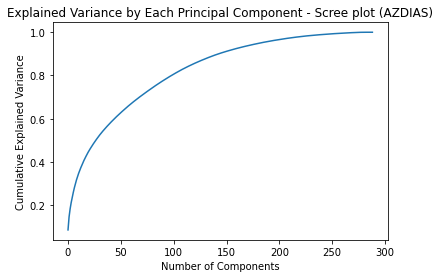

In [75]:
#Scree Azdias

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Each Principal Component - Scree plot (AZDIAS)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

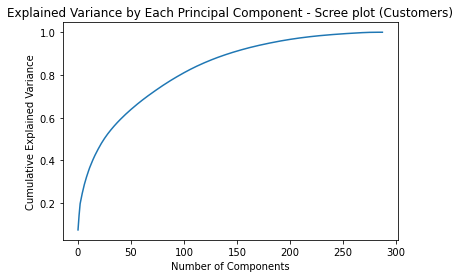

In [76]:
#Scree Customers

customers_pca = pca.fit_transform(customers_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Each Principal Component - Scree plot (Customers)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

We need to choose the number of components/features we want to keep after PCA.

The tradeoff involved is that we need a number of component that is high enough to represent the variabilities of the data, but not too high so that our model is somewhat simpler. Additionally, as we can see from the plots, the curves became less steep after a certain point, or in other words, incremental explained variance does not increase by much with additional components. 

Therefore, judging from the plots, 150 components seems to be the ideal number for both datasets.

In [77]:
def pca_150(df, n=150):
    pca = PCA(n_components=n)
    reduced_df = pca.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df)
    print('The variance in the data explained by the principal components after employing PCA is equal to ' + str(pca.explained_variance_ratio_.sum())) 
    return reduced_df

In [78]:
reduced_azdias = pca_150(azdias_scaled, n=150)
reduced_customers = pca_150(customers_scaled, n=150)

The variance in the data explained by the principal components after employing PCA is equal to 0.9094487343051892
The variance in the data explained by the principal components after employing PCA is equal to 0.9094111973049335


In [79]:
reduced_azdias.shape

(737288, 150)

In [80]:
reduced_customers.shape

(159036, 150)

### Clustering with k-Means

First, we utilize elbow method in order to find the ideal number of clusters by plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

In [81]:
def apply_kmeans(data, k):        
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data)
    return abs(model.score(data))

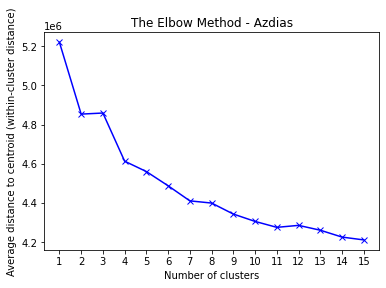

In [82]:
distances = []
possible_clusters = list(range(1,16))

for k in possible_clusters:
    distances.append(apply_kmeans(reduced_azdias.sample(20000), k))
    
plt.plot(possible_clusters, distances, linestyle='-', marker='x', color='blue')
plt.xticks(ticks=possible_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid (within-cluster distance)')
plt.title('The Elbow Method - Azdias')
plt.show()

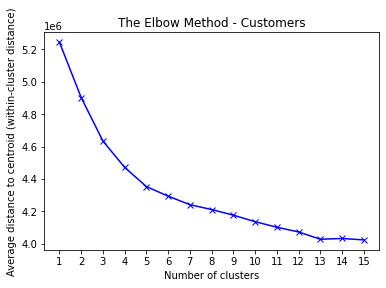

In [83]:
distances = []
possible_clusters = list(range(1,16))

for k in possible_clusters:
    distances.append(apply_kmeans(reduced_customers.sample(20000), k))
    
plt.plot(possible_clusters, distances, linestyle='-', marker='x', color='blue')
plt.xticks(ticks=possible_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid (within-cluster distance)')
plt.title('The Elbow Method - Customers')
plt.show()

From the two plots above, we can see that the elbow is located somewhere around 9-12. Thus, we pick 11 to be the ideal number of clusters.

In [84]:
chosen_number_of_clusters = 11
kmeans = KMeans(n_clusters=chosen_number_of_clusters, random_state=101)

In [85]:
# Azdias - general population clustering

azdias_preds = kmeans.fit_predict(reduced_azdias)
azdias_clustered = pd.DataFrame(azdias_preds, columns = ['Cluster'])

In [86]:
# Customers - customer base clustering

customers_preds = kmeans.fit_predict(reduced_customers)
customers_clustered = pd.DataFrame(customers_preds, columns = ['Cluster'])

In [87]:
azdias_clustered.to_pickle('azdias.pkl')

In [88]:
customers_clustered.to_pickle('customers.pkl')

### Compare % of each clusters

In [89]:
# Get cluster sizes for both datasets
azdias_clusters = pd.Series(azdias_preds)
num_pc = azdias_clusters.value_counts().sort_index()

customers_clusters = pd.Series(customers_preds)
num_cc = customers_clusters.value_counts().sort_index()

In [90]:
# Calculate % of each clusters
summary_df = pd.concat([num_pc, num_cc], axis=1).reset_index()
summary_df.columns = ['Cluster #','General Population','Customer Base']

summary_df['Perct of Total General Pop'] = ( summary_df['General Population'] / (summary_df['General Population'].sum()) * 100 ).round(2)
summary_df['Perct of Total Customer Base'] = ( summary_df['Customer Base'] / (summary_df['Customer Base'].sum()) * 100 ).round(2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

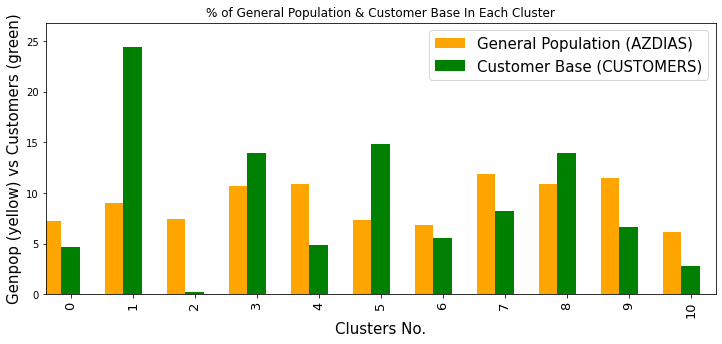

In [91]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)

ax = summary_df['Perct of Total General Pop'].plot(x=summary_df['Cluster #'], width=-0.3, align='edge', color='orange', kind='bar', position=0)
ax = summary_df['Perct of Total Customer Base'].plot(kind='bar', color='green', width = 0.3, align='edge', position=1)

ax.set_xlabel('Clusters No.', fontsize=15) 
ax.set_ylabel('Genpop (yellow) vs Customers (green)', fontsize=15)

ax.xaxis.set(ticklabels=range(11))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General Population (AZDIAS)', 'Customer Base (CUSTOMERS)'), fontsize=15)
plt.title(('% of General Population & Customer Base In Each Cluster'))

plt.show()

As seen above, clusters 2, 4, and 9 are the most underrepresented in the customer base, while on the other hand, clusters 1 and 5 are overrepresented.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [92]:
mailout_train = pd.read_csv('train.csv', index_col=0)

In [93]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [94]:
mailout_train.shape

(42962, 367)

In [95]:
mailout_train_LNR = mailout_train['LNR']

In [96]:
pd.pivot_table(mailout_train, index='RESPONSE', aggfunc='count')

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANREDE_KZ,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
RESPONSE,,,,,,,,,,,,,,,,,,,,,
0,42430,35544,34372,42430,35544,1967,746,170,40,42430,...,42430,35544,34088,35249,35249,35249,35544,34746,32853,42430
1,532,449,435,532,449,21,10,4,1,532,...,532,449,429,446,446,446,449,439,431,532


As seen above, there is an imbalance between responses zero and one (non-customer and customer, respetively). We will resample the customers and balance the data.

In [97]:
Yes_Customer = mailout_train[mailout_train['RESPONSE']==1] 
No_Customer = mailout_train[mailout_train['RESPONSE']==0]

Yes_Customer_balanced = resample(Yes_Customer, replace=True, n_samples=42430, random_state=1) 

mailout_train_balanced = pd.concat([No_Customer, Yes_Customer_balanced])

In [98]:
pd.pivot_table(mailout_train_balanced, index='RESPONSE', aggfunc='count')

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANREDE_KZ,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
RESPONSE,,,,,,,,,,,,,,,,,,,,,
0,42430,35544,34372,42430,35544,1967,746,170,40,42430,...,42430,35544,34088,35249,35249,35249,35544,34746,32853,42430
1,42430,35812,34605,42430,35812,1729,797,323,80,42430,...,42430,35812,34224,35565,35565,35565,35812,34976,34385,42430


In [99]:
# Separate and drop labels
train_y_label = mailout_train_balanced['RESPONSE']
mailout_train_balanced.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [100]:
# Combine all cleaning processes done on azdias and customers earlier to one function, for ease

def cleaning_function(df, attributes, to_drop_nonexistent, columns_to_drop_missing, nan_threshold=0.2):

    # drop features nonexistent 
    df.drop(labels=to_drop_nonexistent, axis=1, inplace=True)
    
    print('after drop features not described' + str(df.shape))
    
    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
    
        
    unknown_series = pd.Series(attributes['Missing Values'].values, index=attributes['Attributes'])

    # convert missing values to NaN
    for column in df.columns:
        isin = ast.literal_eval(unknown_series[column])
        df[column] = df[column].mask(df[column].isin(isin), other=np.nan)
    
    print('after missing values' + str(unknown_series.shape))
    print('after missing values' + str(df.shape))
    
    # drop columns with higher than threshold % NaN
    drop_columns = []
    for column in columns_to_drop_missing:
        if column not in to_drop_nonexistent:
            drop_columns.append(column)
            
    df.drop(labels=drop_columns, axis=1, inplace=True)
    
    print('after drop lower threshold' + str(df.shape))
    
    #re-encoding
    
    cat_feat_df = [] 
    for cat_feat in categorical_features_attributes:
        if cat_feat in df.columns:
            cat_feat_df.append(cat_feat)
    
    mixed_feat_df = [] 
    for mixed_feat in mixed_features_attributes:
        if mixed_feat in df.columns:
            mixed_feat_df.append(mixed_feat)
                   
    binary_num_attributes = []
    binary_non_num_attributes = []
    multi_level_attributes = []

    for attribute in cat_feat_df:
        dtype = df[attribute].dtype
        count = len(df[attribute].value_counts())

        if count > 2:
            multi_level_attributes.append(attribute)
        else:
            if dtype == 'object':
                binary_non_num_attributes.append(attribute)
            else:
                binary_num_attributes.append(attribute)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    list_columns_to_add = []

    for column in multi_level_attributes:
        
        if len(df[column].value_counts()) < 10:
            list_columns_to_add.append(pd.get_dummies(df[column], prefix=column))
    
    
    df.drop(multi_level_attributes, axis=1, inplace=True)

    print('after drop multilevel' + str(df.shape))
    
    list_columns_to_add.append(df) 

    df = pd.concat(list_columns_to_add, axis=1)
    
    print('after adding cols to add' + str(df.shape))
    
    ### df mixed features re-encoding ###
    
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    print('final' + str(df.shape))
    
    return df

In [101]:
# plug in values
not_described_features = to_drop_nonexistent

missing_perct_column = mailout_train_balanced.isnull().mean(axis=0)

columns_to_drop_missing = missing_perct_column[missing_perct_column > 0.2].index

In [102]:
# apply function
train = cleaning_function(mailout_train_balanced, attributes, not_described_features, columns_to_drop_missing, nan_threshold=0.2)

after drop features not described(84860, 334)
after missing values(334,)
after missing values(84860, 334)
after drop lower threshold(84860, 267)
after drop multilevel(84860, 251)
after adding cols to add(84860, 306)
final(84860, 304)


In [103]:
# Impute and Scale
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_imputed = pd.DataFrame(imputer.fit_transform(train))  

scaler = StandardScaler()
train_imputed_scaled = pd.DataFrame(scaler.fit_transform(train_imputed))

In [104]:
train_imputed_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,-0.545612,1.520610,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,-0.469908,...,-0.436067,-0.093728,-0.247522,1.198530,0.231422,-0.474137,0.852874,0.747642,0.081105,0.433009
1,1.832804,-0.657631,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,2.128074,...,0.042079,-0.093728,-0.247522,-0.834355,0.231422,1.626729,0.852874,-0.212931,0.081105,-1.109707
2,1.832804,-0.657631,-0.251387,-0.461684,-0.664275,-0.340877,2.633776,-0.314341,-0.478781,-0.469908,...,1.476515,-0.093728,-0.247522,-0.834355,0.231422,-0.999353,-1.172505,0.747642,-1.441759,0.433009
3,-0.545612,1.520610,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,-0.469908,...,-0.914212,-0.093728,-0.247522,1.198530,0.231422,-1.524570,0.852874,0.747642,-1.441759,0.433009
4,-0.545612,1.520610,-0.251387,-0.461684,-0.664275,-0.340877,-0.379683,-0.314341,2.088636,-0.469908,...,1.476515,-0.093728,-0.247522,-0.834355,0.231422,-0.474137,-1.172505,-0.212931,0.842537,-1.881064


### Grid Search on Classifier Algorithms

First we set up a function to do grid search based on ROC and AUC metrics for the various algorithms we are going to try. 

The inputs to the function will be the classifier, parameter of the classifier to be used with the grid search, and features + labels from the train dataset. Additionally, we also implemented Stratified K-Fold cross-validation splitting strategy.

The function will output the fitted classifier, while printing the time taken to train.

In [105]:
# training grid search function
def gridsearch_classifier(classifier, param_grid, X_train, y_train):
    # using StratifiedKFold
    
    start = time.time()
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    
    end = time.time()
    print('/n')
    print('Time Taken:' + str(end-start))
    print(grid.best_score_)
    return grid.best_estimator_

#### 1. Benchmark Model - Logistic Regression

Our benchmark model is the Logistic Regression classifier since this is the standard model with 1 as “converted into new customer” score and 0 as the “not converted into new customer” score.

In [106]:
logistic = LogisticRegression(random_state=101)
print(gridsearch_classifier(logistic, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:17.068783044815063
0.8079572243568297
LogisticRegression(random_state=101)


> #### Logistic Regression: Time Taken: 17.1 seconds, AUC = 0.808

#### 2. Potential Models
Decision Tree Classifier <br>
Random Forest Classifier <br>
AdaBoost Classifier <br>
Gradient Boosting Classifier <br>
Multilayer Perceptron (Neural Network) Classifier <br>

In [107]:
tree = DecisionTreeClassifier(random_state=101)
rf = RandomForestClassifier(random_state=101)
adaboost = AdaBoostClassifier(random_state=101)
gbc = GradientBoostingClassifier(random_state=101)
mlp_nn = MLPClassifier(random_state=101, alpha=1, max_iter=100)

In [108]:
print(gridsearch_classifier(tree, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:56.231369972229004
0.9846861787133946
DecisionTreeClassifier(random_state=101)


In [109]:
print(gridsearch_classifier(rf, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:184.84636998176575
0.9933737501908706
RandomForestClassifier(random_state=101)


In [110]:
print(gridsearch_classifier(adaboost, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:133.06420803070068
0.7859658744471563
AdaBoostClassifier(random_state=101)


In [111]:
print(gridsearch_classifier(gbc, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:607.3762629032135
0.8886038998171919
GradientBoostingClassifier(random_state=101)


In [112]:
print(gridsearch_classifier(mlp_nn, {}, train_imputed_scaled, train_y_label))

/n
Time Taken:637.5171508789062
0.9903483737671325
MLPClassifier(alpha=1, max_iter=100, random_state=101)


### Model Selection + Fine Tuning The 'Best' Model

As seen from the results of the 9 different classifiers, Random Forest and Multilayer Perceptron (Neural Network) performed really well in terms of AUC but took longer than the others. Decision Tree performed only slightly worse than Random Forest, but took only about one-third of Random Forest's duration.

The problem with the three classifiers mentioned above is that the scores are 'too good to be true' and thus might be caused by overfitting.

Therefore, we choose the next best performing model despite the longer duration, which is the Gradient Boosting Classifier (GB), as the model that we will select and optimize further using GridSearchCV to fine-tune the hyperparameters.

In [117]:
#Define the possible hyperparameters (loss type and max depth) for the GB
param_grid = {'loss': ['deviance','log_loss', 'exponential'],
              'max_depth': list(range(3,5))
             }

gbc_best_estimator = gridsearch_classifier(gbc, param_grid, train_imputed_scaled, train_y_label)

/n
Time Taken:2269.597023010254
0.9492743007031754


In [118]:
gbc_best_estimator

GradientBoostingClassifier(max_depth=4, random_state=101)

### Comparison with Benchmark

Our chosen trained GB model performed better in comparison to the benchmark (logistic regression), with a higher AUC of the ROC curve:

0.949 > 0.808

For the Kaggle Competition submission/test dataset, we will use the GB model with the tuned hyperparameters 'max_depth' of 4.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.



In [133]:
mailout_test = pd.read_csv('test.csv', index_col=0)

In [134]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [135]:
mailout_test.shape

(42833, 366)

In [136]:
test_LNR = mailout_test['LNR']

In [137]:
# apply function for cleaning - use same parameters as train data in terms of columns to drop
test = cleaning_function(mailout_test, 
                          attributes, 
                          not_described_features, 
                          columns_to_drop_missing, 
                          nan_threshold=0.2)

after drop features not described(42833, 334)
after missing values(334,)
after missing values(42833, 334)
after drop lower threshold(42833, 267)
after drop multilevel(42833, 251)
after adding cols to add(42833, 306)
final(42833, 304)


In [138]:
test.head()

,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,...,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
0,0,1,0,0,0,0,0,1,0,0,...,7.0,0.0,0.0,1.0,9.0,3.0,1.0,4.0,1.0,3.0
1,0,0,0,1,0,0,0,0,0,0,...,6.0,0.0,0.0,1.0,9.0,5.0,1.0,4.0,3.0,1.0
2,0,1,0,0,1,0,0,0,0,0,...,3.0,0.0,1.0,1.0,9.0,4.0,2.0,4.0,4.0,1.0
3,0,0,0,0,0,0,1,0,0,0,...,2.0,0.0,0.0,2.0,9.0,2.0,2.0,4.0,1.0,3.0
4,1,0,0,0,0,0,0,0,1,1,...,3.0,0.0,0.0,1.0,9.0,7.0,2.0,4.0,3.0,1.0


In [139]:
test.shape

(42833, 304)

In [140]:
# Impute and Scale
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
test_imputed = pd.DataFrame(imputer.fit_transform(test))  

scaler = StandardScaler()
test_imputed_scaled = pd.DataFrame(scaler.fit_transform(test_imputed))

### Classification with Chosen Model ()

In [143]:
# Calculate prediction probabilities for the TEST set with previously trained GradientBoostingClassifier estimator
test_gbc_preds = gbc_best_estimator.predict_proba(test_imputed_scaled)

### CSV File for Kaggle Submission
Columns: the LNR id column + prediction of response column

In [144]:
submission = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':test_gbc_preds[:, 1]})
submission.to_csv('submission.csv', index=False)
submission.head()

,LNR,RESPONSE
0,1754,0.636801
1,1770,0.635613
2,1465,0.179187
3,1470,0.042028
4,1478,0.059016


In [145]:
len(submission[submission['RESPONSE']>0.5])

6133

Out of 42,833 individuals (rows in the test dataset), 6,133 individuals seems likely to become a customer (predicted individual probability to join is greater than 0.5). This 6,133 is approximately 14.2% of the total test individuals.